In [151]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt

%matplotlib inline

In [152]:
df = pd.read_csv('credit_card_clients.csv', sep=';')
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [153]:
df.rename(columns={'default payment next month': 'defolts'}, inplace=True)
df.drop(columns=['ID'])

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defolts
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [154]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['defolts']), df['defolts'], random_state=0)

In [155]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [156]:
continuous_columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
                     'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [157]:
# Теперь нам нужно под каждый признак создать трансформер и объединить их в список 
# (сделаем это в цикле, чтобы не мучиться)

from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))


In [158]:
# Объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [159]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [160]:
# Создаем пустой датафрейм для хранения результатов
results_df = pd.DataFrame(columns=['Model', 'Thresholds', 'Precision', 'Recall', 'F1-score', 'roc_auc'])

In [161]:
# Добавим модель
from xgboost import XGBClassifier

pipeline_xgb = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(random_state=42)),
])
# обучим наш пайплайн
pipeline_xgb.fit(X_train, y_train)
# прогнозы для тестовой выборки
preds = pipeline_xgb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.6567332 , 0.40282777, 0.24700418, 0.05180289, 0.02451317,
       0.5900706 , 0.06145059, 0.16463439, 0.10704857, 0.16646466],
      dtype=float32)

In [162]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)
new_row = pd.DataFrame({'Model': ['XGBClassifier'],
                        'Thresholds': [thresholds[ix]],
                        'Precision': [precision[ix]],
                        'Recall': [recall[ix]],
                        'F1-score': [fscore[ix]],
                        'roc_auc': [roc_auc]})
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df

Best Threshold=0.279194, F-Score=0.523, Precision=0.499, Recall=0.550


,Model,Thresholds,Precision,Recall,F1-score,roc_auc
0,XGBClassifier,0.279194,0.499166,0.550245,0.523463,0.764685


In [148]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [149]:
df_shap = pd.read_csv("credit_card_clients.csv", sep=';')
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
                     'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df_shap.rename(columns={'default payment next month': 'defolts'}, inplace=True)
df_shap.drop(columns=['ID'])
df_shap.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defolts
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [150]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df_shap[features], df_shap['defolts'], random_state=0)


In [101]:
import xgboost
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

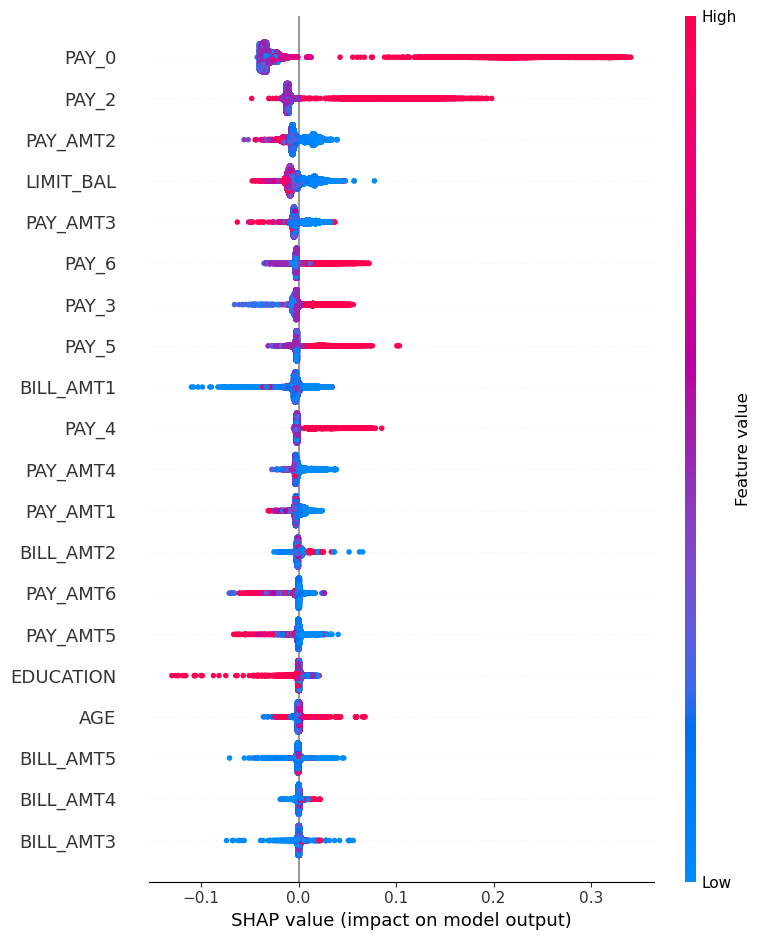

In [102]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

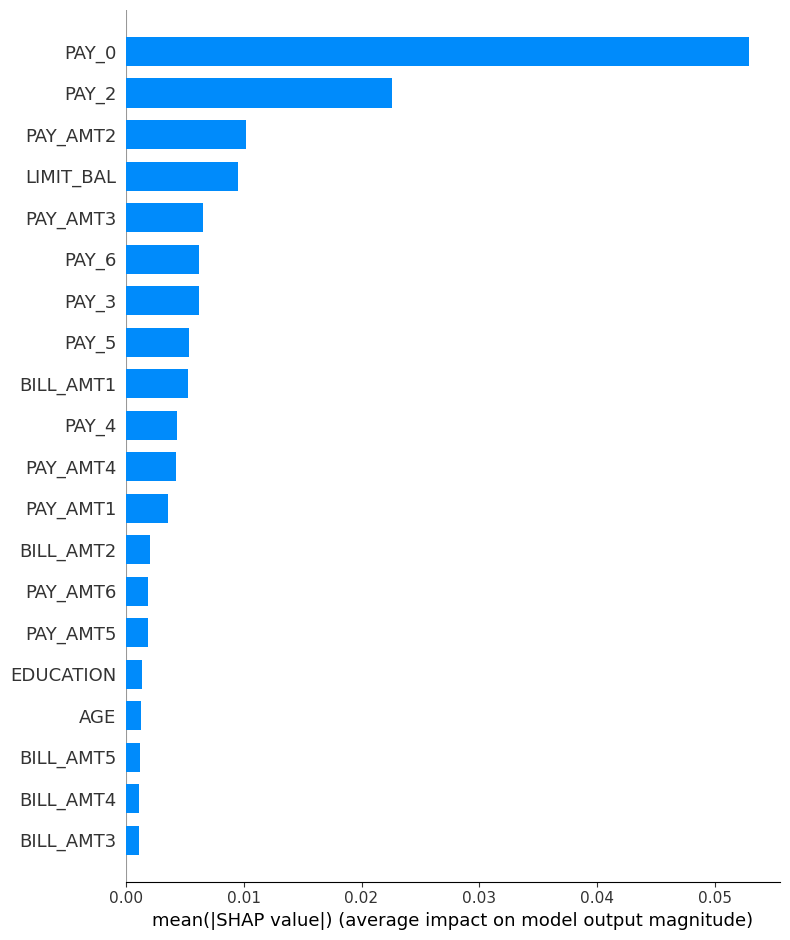

In [103]:
#Можно даже просто взять средние значения SHAP для каждого признака
shap.summary_plot(shap_values, X_train, plot_type="bar")

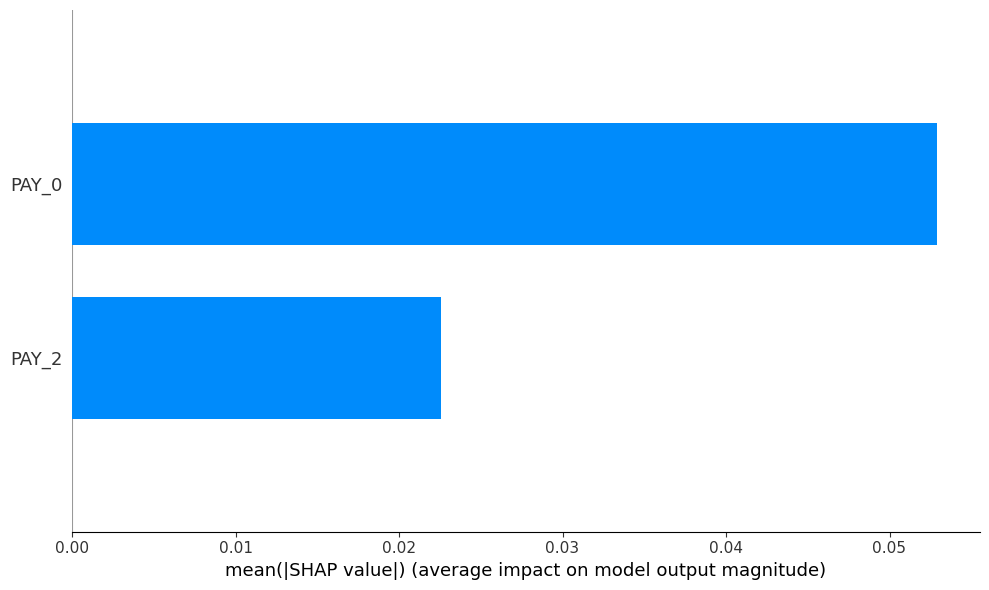

In [104]:
# get the top 10% features by absolute SHAP value
top_k = int(X_train.shape[1] * 0.1)
top_features_idx = np.argsort(np.abs(shap_values).mean(0))[-top_k:]

# plot the summary plot only for the top 10% features
shap.summary_plot(shap_values[:, top_features_idx], X_train.iloc[:, top_features_idx], 
                   plot_type="bar", plot_size=(10,6))

In [105]:
# выводим force plot для первого наблюдения
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

#### веорятность дефолта у этого человека не велика, по основным признакам все хорошо

In [106]:
# выводим force plot для 5 наблюдения
shap.force_plot(explainer.expected_value, shap_values[4, :], X_train.iloc[4, :])

#### веорятность дефолта у этого человека заметно выше, признаки EDUCATION и PAY_0  изменяет значение в сторону дефолта

In [108]:
# выводим force plot для 20 наблюдения
shap.force_plot(explainer.expected_value, shap_values[19, :], X_train.iloc[4, :])

#### веорятность дефолта у этого человека тоже высокая, красных признаков больше и судя по всему они имеют "больший вес"  и изменяют  значение в сторону дефолта

In [109]:
# выводим force plot для 25 наблюдения
shap.force_plot(explainer.expected_value, shap_values[24, :], X_train.iloc[9, :])

#### более сбалансированный force plot, но все равно признаки "тянут" значение в сторону дефолта